# NeuroML → Jaxley Tutorial

This tutorial walks through:

- Part 1: Model Specification in Jaxley (cells, channels, synapses), including custom Calcium channel and graded/differentiable synapse aligned with c302 C-level.
- Part 2: Connectome Translation from c302 NeuroML to a Jaxley network using `c302.neuroml_to_jaxley`.
- Part 3: Simulation, visualization, and a simple gradient-based optimization on network and stimulus parameters.

Requirements: `jax`, `jaxley`, `matplotlib`, `pytest`, and the `c302` package code (clone into this folder from [c302 repository](https://github.com/openworm/c302)).

Create the virtual environment `python -m venv .venv`

Install `pip install jax jupyter ipykernel`

Run `pip install . in the c302 directory`

Run the kernel



In [1]:
#imports

import jax
jax.config.update('jax_platform_name', 'cpu')
import jaxley as jx
import jax.numpy as jnp


from custom_mechanisms import (
    VGCaChannel,
    GradedChemicalSynapse,
    DifferentiableExpTwoSynapse,
    GapJunctionSynapse,
)

from neuroml_to_jaxley import *
import matplotlib.pyplot as plt



## Part 1: Model Specification

We will use the existing HH (Na, K, Leak) channel from Jaxley and add:
- a minimal voltage-gated Ca channel (e+f gates) `VGCaChannel`
- a differentiable, C-like two-exponential chemical synapse `DifferentiableExpTwoSynapse`
- a simple gap junction synapse `GapJunctionSynapse`

These are defined in `custom_mechanisms.py`.


## Internals: Modules and parameter names

- Cells/branches/compartments: `jx.Cell → jx.Branch → comp(index)`; global vs local scopes enable vectorized selection (`cell("all").branch(0)`).
- Channels: built-ins (HH) expose `HH_*` parameter names, e.g., `HH_gNa`, consistent with c302 mapping.
- Synapses:
  - IonotropicSynapse (built-in): `IonotropicSynapse_gS`, `IonotropicSynapse_e_syn`, `IonotropicSynapse_v_th`, `IonotropicSynapse_delta`, `IonotropicSynapse_k_minus`.
  - Custom `GradedChemicalSynapse` and `DifferentiableExpTwoSynapse` accept both their own keys and IonotropicSynapse aliases for compatibility with the translator.
- Gap junction: use built-in `GapJunction` when available; custom `GapJunctionSynapse` also accepts `GapJunction*_gGap` or bare `gGap`.


### Part 1.1: Create a demo cell and insert channels

We create a single-compartment cell and insert HH and a minimal Ca channel. This cell will be duplicated to form a 2-cell micro-network.


In [2]:
# Build a small demo cell with HH + VGCa
comp = jx.Compartment()
branch = jx.Branch(comp, ncomp=1)
cell = jx.Cell(branch, parents=[-1])
cell.insert(jx.channels.HH())
cell.insert(VGCaChannel())


### Part 1.2: Build a 2-cell network and connect with a synapse

We duplicate the cell into a network with two cells and connect them using the differentiable two-exponential synapse.


In [3]:
# Build 2-cell network and connect
cells = [cell, cell]
net = jx.Network(cells)
pre = net.cell(0).branch(0).loc(0.0)
post = net.cell(1).branch(0).loc(0.0)

syn = DifferentiableExpTwoSynapse()
jx.connect(pre, post, syn)

# Record
net.cell(0).branch(0).loc(0.0).record()
net.cell(1).branch(0).loc(0.0).record()


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


### Part 1.3: Stimulate and simulate the micro-network

We inject a simple pulse into the presynaptic cell and integrate the network, plotting both traces.


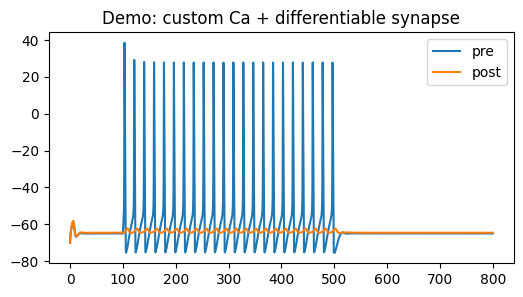

In [4]:
# Stimuli and simulation for Part 1
inputs_flat = [{"population": 0, "delay_ms": 100.0, "duration_ms": 400.0, "amplitude_A": 4e-12}]
currents = pulses_to_currents(inputs_flat, dt_ms=0.05, t_max_ms=800.0, out_unit="nA")
data_stimuli = net.cell(0).branch(0).comp(0).data_stimulate(jnp.asarray(currents[0], dtype=jnp.float32), None)
V = jx.integrate(net, delta_t=0.05, t_max=800.0, data_stimuli=data_stimuli)

t = np.arange(0.0, 800.0 + 0.05, 0.05)
plt.figure(figsize=(6,3))
plt.plot(t, V[0], label='pre')
plt.plot(t, V[1], label='post')
plt.legend(); plt.title('Demo: custom Ca + differentiable synapse'); plt.show()


## Part 2: Connectome Translation

We translate from c302 NeuroML into an intermediate spec and then into a Jaxley network. This applies unit conversions and maps parameters to the custom mechanisms defined above.


### Part 2.1: Translate NeuroML to an intermediate spec

We generate a c302 preset, parse NeuroML into a structured `NetworkSpec`, and apply defaults.


In [9]:
# Load and translate a preset (level C)
inter = load_c302_preset_to_intermediate("C")
inter = apply_meta_defaults(inter, meta_policy_from_bioparams(inter.meta))


c302      >>>  Set default parameters for C
cect      >>>  Initialising SpreadsheetDataReader...
cect      >>>  Opened sheet 0 in Excel file: c:\Users\evanc\OneDrive\Desktop\Research\voltworm\.venv\Lib\site-packages\cect/data/CElegansNeuronTables.xls
cect      >>>  Opened sheet 1 in Excel file: c:\Users\evanc\OneDrive\Desktop\Research\voltworm\.venv\Lib\site-packages\cect/data/CElegansNeuronTables.xls
cect      >>>  Opened sheet 0 in Excel file: c:\Users\evanc\OneDrive\Desktop\Research\voltworm\.venv\Lib\site-packages\cect/data/CElegansNeuronTables.xls
cect      >>>  Initialising SpreadsheetDataReader...
cect      >>>  Opened sheet 0 in Excel file: c:\Users\evanc\OneDrive\Desktop\Research\voltworm\.venv\Lib\site-packages\cect/data/CElegansNeuronTables.xls
cect      >>>  Opened sheet 1 in Excel file: c:\Users\evanc\OneDrive\Desktop\Research\voltworm\.venv\Lib\site-packages\cect/data/CElegansNeuronTables.xls
cect      >>>  Opened sheet 0 in Excel file: c:\Users\evanc\OneDrive\Desktop\Res

### Part 2.2: Build a Jaxley network from the intermediate spec

We convert to Jaxley parameters, build the network, and visualize a 2D projection with synapses.


In [10]:
bundle = translate_intermediate_to_jaxley_params(inter)
built = build_jaxley_from_params(inter, bundle)

print(f"Cells: {len(inter.cells)}  Connections: {len(inter.conns)}")

ax = built.net.vis(
    detail="point", dims=(1, 2),
    color="k", synapse_color="g",
    synapse_scatter_kwargs={"s": 10, "alpha": 0.7, "zorder": -1},
    synapse_plot_kwargs={"alpha": 0.5, "zorder": -1}
)
ax.set_title("C. elegans Connectome", fontsize=12)
ax.set_xlabel('x (µm)'); ax.set_ylabel('y (µm)')


Building cell 0 of 302 ADAL
Building cell 100 of 302 DB4
Building cell 200 of 302 RIMR
Building cell 300 of 302 VD8
Edges: 3363
Building edge 0 of 3363 ADAL->AIBL:chem:NC_ADAL_AIBL_Glutamate:neuron_to_neuron_exc_syn:0
Building edge 100 of 3363 ADLL->AVAR:chem:NC_ADLL_AVAR_FMRFamide:neuron_to_neuron_exc_syn:0
Building edge 200 of 3363 AIMR->PVNR:chem:NC_AIMR_PVNR_Serotonin:neuron_to_neuron_exc_syn:0
Building edge 300 of 3363 AS1->DA1:chem:NC_AS1_DA1_Acetylcholine:neuron_to_neuron_exc_syn:0
Building edge 400 of 3363 AUAL->AVAL:chem:NC_AUAL_AVAL_Glutamate:neuron_to_neuron_exc_syn:0
Building edge 500 of 3363 AVBL->AS5:chem:NC_AVBL_AS5_Glutamate:neuron_to_neuron_exc_syn:0
Building edge 600 of 3363 AVER->DB3:chem:NC_AVER_DB3_FMRFamide:neuron_to_neuron_exc_syn:0


## Part 3: Simulation and Optimization

We’ll stimulate a small subset of neurons from the c302 inputs and optimize a synaptic parameter with a simple loss.


## Internals: Solver and stability

- Time-stepping uses exact updates for first-order linear gates: `exponential_euler / solve_inf_gate_exponential` with `save_exp` to avoid overflow.
- Stability tips:
  - Guard small denominators (taus, deltas) with `jnp.maximum`.
  - Use physiologically plausible bounds for gS, taus, thresholds.
  - Clip voltages in the loss and use `jnp.nan_to_num` to prevent NaN propagation.


### Part 3.1: Stimulus preparation and recording selection

We prepare currents from c302 inputs, attach them via `data_stimulate`, and choose a few cells to record from.


In [ ]:
# Build stimuli and recordings for Part 3
inputs_flat = inter.meta.get("inputs", [])
from neuroml_to_jaxley import pulses_to_currents, attach_currents_via_datastim

currents = pulses_to_currents(inputs_flat, dt_ms=0.05, t_max_ms=500.0, amp_scale=1.0, out_unit="nA")

data_stimuli, idxs = attach_currents_via_datastim(built.net, built.id_to_index, currents)

if hasattr(built.net, "delete_recordings"):
    built.net.delete_recordings()
for i in idxs[:5]:
    built.net.cell(i).branch(0).loc(0.0).record("v")


### Part 3.2: Integrate and visualize

We integrate the built network with attached stimuli and visualize a few recorded voltages.


In [ ]:
V = jx.integrate(built.net, delta_t=0.05, t_max=500.0, data_stimuli=data_stimuli)

t = np.arange(0.0, 500.0 + 0.05, 0.05)
plt.figure(figsize=(8,4))
for k in range(min(5, V.shape[0])):
    plt.plot(t, V[k], label=f"cell[{k}]")
plt.legend(); plt.title("Stimulus responses"); plt.show()


### Data I/O: Stimuli and recordings

- `pulses_to_currents`: converts flattened c302 pulses into per-population traces (choose `out_unit="nA"`).
- `attach_currents_via_datastim`: attaches np arrays directly to compartments with `data_stimulate`.
- Recording:
  - Use `.record("v")` or bare `.record()` per location. Access via `.recordings` or capture returned array from `integrate`.
  - Recommended: clear prior recordings with `net.delete_recordings()` when iterating.


### Internals: Parameter transforms and training
- Jaxley parameters live in a PyTree of dicts (`get_parameters`). Views (e.g., `net.IonotropicSynapse.edge(i)`) mark subsets trainable.
- `ParamTransform` maps unconstrained → constrained space. Use `forward(x)` before `integrate`, and `inverse(y)` to go from initial constrained params to an unconstrained optimization state.
- Good practice:
  - Build bounds from current params (per-element) and expand slightly.
  - Initialize in unconstrained space via `inverse` after clipping to open interval.
  - Use small `delta_t` and `t_max` during training; add gradient clipping.
  - Only optimize a few parameters at first (e.g., `HH_gLeak`, then add `HH_gNa`, `HH_gK`).


In [ ]:
# Optimize cell (HH) parameters
import optax
import jaxley.optimize.transforms as jt
jax.config.update("jax_debug_nans", False)
# Reset previous trainables and make HH parameters trainable on a small subset
built.net.delete_trainables()
try:
    target_cells = idxs[:3]
except NameError:
    target_cells = [0]

built.net.cell(target_cells).make_trainable("HH_gNa")
# built.net.cell(target_cells).make_trainable("HH_gK")
# built.net.cell(target_cells).make_trainable("HH_gLeak")

params = built.net.get_parameters()

class ClipTransform(jt.Transform):
    def __init__(self, lower: float, upper: float):
        self.lower = lower
        self.upper = upper

    def forward(self, x: jnp.ndarray) -> jnp.ndarray:
        return jnp.clip(x, self.lower, self.upper)

    def inverse(self, y: jnp.ndarray) -> jnp.ndarray:
        return jnp.clip(y, self.lower, self.upper)

def build_dynamic_transforms(params_list, keys, frac=0.1, min_width=1e-6):
    tfs = []
    for p in params_list:
        tdict = {}
        for k, v in p.items():
            if k in keys:
                width = jnp.maximum(jnp.abs(v) * frac, min_width)
                lower = v - width 
                upper = v + width
                print(lower)
                print(upper)
                tdict[k] = ClipTransform(lower, upper)
            else:
                tdict[k] = jt.CustomTransform(lambda x: x, lambda x: x)
        tfs.append(tdict)
    return tfs



# Create per-parameter transforms matching the tree structure
# Ranges for HH conductances (mS/cm^2) chosen for stability:
# - HH_gNa in [0.01, 1.0]
# - HH_gK  in [0.005, 0.5]
# - HH_gLeak in [1e-5, 0.01]


keys = ["HH_gNa"]  # add "HH_gK", "HH_gLeak" when stable
transforms = build_dynamic_transforms(params, keys, frac=0.1, min_width=1e-6)
transform = jx.ParamTransform(transforms)

# Sanitize initial parameters into transform domain to avoid NaNs on inverse

# Initialize in unconstrained space
# Clip initial values away from transform bounds to avoid inverse singularities

def clip_into_bounds(p_list, tf_list, eps=1e-8):
    out = []
    for p, tfd in zip(p_list, tf_list):
        q = {}
        for k, v in p.items():
            tf = tfd.get(k)
            if isinstance(tf, jt.SigmoidTransform):
                lo = tf.lower
                hi = tf.lower + tf.width
                q[k] = jnp.clip(v, lo + eps, hi - eps)
            else:
                q[k] = v
        out.append(q)
    return out

params0 = clip_into_bounds(params, transforms)
opt_params = transform.inverse(params0)

print(opt_params)

label = -10.0  # target mV

# Define simulate and loss with simple safeguards

def simulate_with_params(opt_params):
    p = transform.forward(opt_params)  # map unconstrained → bounded
    return jx.integrate(built.net, params=p, delta_t=0.01, t_max=100.0, data_stimuli=data_stimuli)

@jax.jit
def loss_fn(opt_params):
    V = simulate_with_params(opt_params)
    V = jnp.nan_to_num(V, nan=-70.0, posinf=0.0, neginf=0.0)
    # V = jnp.clip(V, -120.0, 60.0)
    target = -10.0
    val = jnp.mean((V - target) ** 2)
    return val, V

optimizer = optax.chain(optax.clip_by_global_norm(0.1), optax.adam(1e-10))
opt_state = optimizer.init(opt_params)

def plot_voltage_traces(vv, num_neurons=3):
    time_vec = np.arange(vv.shape[1])
    fig = plt.figure(figsize=(10, 6))
    for neuron_idx in range(min(num_neurons, vv.shape[0])):
        plt.plot(time_vec, vv[neuron_idx], label=f"Neuron {neuron_idx}")
    plt.xlabel("Timestep")
    plt.ylabel("Voltage (mV)")
    plt.title(f"Voltage Traces for {min(num_neurons, vv.shape[0])} Neurons")
    plt.legend()
    plt.tight_layout()
    return fig

def nan_to_num_in_list(data_list, nan_val=0.0):
    return [{key: jnp.nan_to_num(value, nan=nan_val, posinf=nan_val, neginf = nan_val) 
             for key, value in d.items()} 
            for d in data_list]


for epoch in range(3):
    (val, V), grad = jax.value_and_grad(loss_fn, has_aux=True)(opt_params)
    plot_voltage_traces(V, num_neurons=3)
    updates, opt_state = optimizer.update(grad, opt_state)
    opt_params = optax.apply_updates(opt_params, updates)
    print(f"epoch {epoch} loss {float(val):.4f}")
